# Coastal flood impacts

## Risk assessment methodology

Same approach as for river flooding, different flooding dataset (ref river flooding workflow).

- Coastal flood extent and inundation depth: available from ... for different return periods and climate scenarios. Flood maps are based on sea level data for a range of return periods in combination with a high-resolution global land elevation dataset (MERIT DEM). Resolution of 30 arc-seconds (300-750 m in European geographical area) is used. The effect of climate change is accounted for by superimposing sea level rise on the water level values (KNMI).

## Preparation work

### Load libraries

In [1]:
# Package for downloading data and managing files
import os
import pooch

# Packages for working with numerical data and tables
import numpy as np
import pandas as pd

# Packages for handling geospatial maps and data
import rioxarray as rxr
import xarray as xr
import rasterio
from rasterio.enums import Resampling

# Package for calculating flood damages
from damagescanner.core import RasterScanner

# Ppackages used for plotting maps
import matplotlib.pyplot as plt
import contextily as ctx
import regionmask
from cartopy import crs as ccrs
import cartopy.feature as cfeature

### Create the directory structure

In [2]:
# Define the folder for the flood workflow
workflow_folder = 'coastal_flood_workflow'

# Check if the workflow folder exists, if not, create it along with subfolders for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(workflow_folder, 'data'))
    os.makedirs(os.path.join(workflow_folder, 'results'))

In [3]:
# Define directories for data and results within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, 'data')
results_dir = os.path.join(workflow_folder, 'results')

# Retrieve coastal flood dataset

In [4]:
# Define source directory for dataset (TODO: change to an online source once available)
floodmap_dir = r'C:\Users\aleksand\OneDrive - Stichting Deltares\Documents\Projects\CLIMAAX\Coastal_flooding\floodmaps_dataset'

# Define a list of return periods 
return_periods = [1,10,50,100,500,1000] # [1,2,5,10,25,50,100,250,500,1000]
years = [2020,2030,2050,2080]
rcps = ['rcp26','rcp45','rcp60','rcp85']
percs = [50,95]

# Define geographical area of interest

#bbox = [1.983871,41.252461,2.270614,41.449569] # Barcelona, Spain
#areaname = 'Barcelona'

bbox = [-2.94,51.4,-2.5,51.7] 
areaname = 'Bristol'

#bbox = [-1.6,46,-1.05,46.4] 
#areaname = 'La_Rochelle'

#bbox = [12.1,45.1,12.6,45.7] 
#areaname = 'Venice'

In [47]:
# load flood maps for different scenarios and years in one array, clipped to region of interest
for year in years:
    for rp in return_periods:
        for rcp in rcps:
            for perc in percs:
                if (perc==95) & (rcp != 'rcp85'):
                    continue
                
                # load dataset
                if year==2020:
                    ext = f'{year}_rp{rp:04}_slr0_nosub'
                    data_path = os.path.join(floodmap_dir,'01_current_climate',f'model_input_{ext}','output',f'inuncoast_ext_{ext}.nc')                 
                else:
                    ext = f'{year}_rp{rp:04}_slr_{rcp}_Perc{perc}_nosub'
                    data_path = os.path.join(floodmap_dir,'03_future_nosub',f'model_input_{ext}','output',f'inuncoast_ext_{ext}.nc')
                    
                if not os.path.isfile(data_path):
                    continue

                # open dataset for the given scenario, year and return period
                ds = xr.open_dataset(data_path,decode_coords="all").drop_vars(['time']).squeeze()['inun']

                # reproject to European projection coordinates
                ds.rio.write_crs("epsg:4326", inplace=True)
                ds1 = ds.rio.clip_box(minx=-16.1, miny=40.18, maxx=32.88, maxy=84.73, crs="EPSG:4326"); del ds # clip to Europe to reduce amount of data to be reprojected
                ds2 = ds1.rio.reproject("epsg:3035"); del ds1
                ds3 = ds2.rio.clip_box(*bbox, crs="EPSG:4326"); del ds2
                ds3 = ds3.where(ds3 > 0,np.nan)
                ds = ds3; del ds3
                
                # add coordinates to specify year, rp, scenario to prepare dataset for merging
                ds = ds.assign_coords(year=year); ds = ds.expand_dims('year')
                ds = ds.assign_coords(return_period=rp); ds = ds.expand_dims('return_period')
                ds = ds.assign_coords(scenario=rcp); ds = ds.expand_dims('scenario')
                ds = ds.assign_coords(slr_percentile=perc); ds = ds.expand_dims('slr_percentile')

                if (year==years[0]) & (rp==return_periods[0]) & (rcp==rcps[0]) & (perc==percs[0]):
                    floodmaps = ds
                else:
                    floodmaps = xr.merge([floodmaps,ds])
                del ds
                    

In [ ]:
# Define functions useful for plotting

def plot_extent(r, floodmap):
    e, s, w, n = r.polygon.bounds
    aspect = abs((w-e)/(n-s))
    fig = plt.figure(figsize=(8, 8/aspect))
    ax = prudence[[r.number]].plot(add_ocean=True, resolution='50m',projection=ccrs.PlateCarree(), add_label=False, 
                                              line_kws={'linewidth': 0.}) 
    ax.set_aspect('equal')
    grid = ax.gridlines(draw_labels=True)
    grid.top_labels = False
    grid.right_labels = False
    ax.add_feature(lakes, alpha=0.4)
    ax.add_feature(riv, alpha=0.4)
    ax.add_feature(borders, alpha=0.4)
    qm = floodmap.plot(ax=ax, vmin=0, vmax=3.0,add_colorbar = False,cmap='turbo')
    cbar = set_colorbar(ax, qm, label='Flood depth [m+MSL]')
    return fig, ax

def set_colorbar(ax, im, wspace=0.02, width=0.015, rel_height=0.5, label='', extend='neither', inset_bottom=True):
    # make colorbar
    fig = plt.gcf()
    cbar_ax = fig.add_axes([1, 1, 0.1, 0.1]) # new ax
    cbar = fig.colorbar(im, extend=extend, cax=cbar_ax)
    cbar.ax.set_ylabel(label, rotation='vertical')
    posn = ax.get_position()
    h = posn.height * rel_height
    y0 = posn.y0 + posn.height - h
    if inset_bottom:
        y0 = posn.y0
    cbar_ax.set_position([posn.x1 + wspace, y0, width, h])
    return cbar

wc = cfeature.COLORS['water']
riv = cfeature.NaturalEarthFeature(name='rivers_lake_centerlines', category='physical', scale='50m', 
                                   facecolor='none', edgecolor=wc, )
lakes = cfeature.NaturalEarthFeature(name='lakes', category='physical', scale='50m', 
                                   facecolor=wc, edgecolor=wc, )
borders = cfeature.NaturalEarthFeature(name='admin_0_countries', category='cultural', scale='50m', 
                                   facecolor='none')

In [ ]:
# TO BE REMOVED
# CHECKPLOTS for European regions
# Plot maps for all years and scenarios for different European regions

bbox = [-10.5,36,31,71.2] # Europe 

plot_dir = os.path.join(data_dir,'floodmap_plots_European_regions')
if not os.path.isdir(plot_dir): os.makedirs(plot_dir)

for year in years[1:]:
    for rp in return_periods:
        for rcp in rcps:
            for perc in percs:
                if (perc==95) & (rcp != 'rcp85'):
                    continue
                
                # load dataset
                ext = f'{year}_rp{rp:04}_slr_{rcp}_Perc{perc}_nosub'
                data_path = os.path.join(floodmap_dir,'03_future_nosub',f'model_input_{ext}','output',f'inuncoast_ext_{ext}.nc')
                floodmap = xr.open_dataset(data_path).drop_vars(['time']).squeeze()['inun']
                floodmap = floodmap.sel(lon=slice(bbox[0], bbox[2]), lat=slice(bbox[1], bbox[3])).load()
                floodmap = floodmap.where(floodmap > 0,np.nan)

                # plot dataset per region
                mask = prudence.mask_3D(floodmap.lon, floodmap.lat)
                
                for prudence_region in np.arange(1, 8, 1):
                    r= prudence.regions[prudence_region]
                    floodmap_region = floodmap.where(mask.sel(region=prudence_region),drop=True)
                    fig, ax = plot_extent(r, floodmap_region); del floodmap_region
                    title_sup = 'permanent inundation' if rp == 0 else 'Flood depth at 1/{:0.0f} years water level'.format(rp)
                    ax.set_title('Flood maps for extreme sea level rise scenarios \n' + title_sup + '\n' + r.name + ' region', size=14)
                    fn = os.path.join(plot_dir,'Floodmap_region_{}_{}_rp{:04d}_Perc{}.png'.format(r.name, rcp, rp, perc))
                    plt.savefig(fn, bbox_inches='tight', dpi=225)
                    plt.close()

#### Land-use information

In [6]:
# Define the URL for the LUISA basemap and download it using Pooch
url = 'http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/2018/VER2021-03-24/LUISA_basemap_020321_100m.tif'
pooch.retrieve(
    url=url,
    known_hash=None,  # Hash value is not provided
    path=data_dir,    # Save the file to the specified data directory
    fname='LUISA_basemap_020321_100m.tif'  # Save the file with a specific name
)

SHA256 hash of downloaded file: adcc1299edb31fe2db39cedc0e56aaf7ca7d3dd800d9b8da01e4ff23374d3cdd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


'C:\\Users\\aleksand\\OneDrive - Stichting Deltares\\Documents\\git_checkouts\\CLIMAAX\\FLOODS\\coastal_flood_workflow\\data\\LUISA_basemap_020321_100m.tif'

#### Damage curves

We will use damage curves files from the JRC.


Text(0, 0.5, 'Damage ratio [%]')

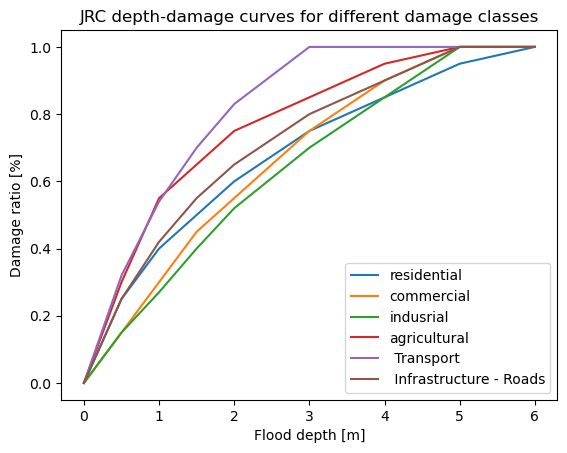

In [7]:
# Import damage curves of the JRC from a CSV file into a pandas DataFrame
JRC_curves = pd.read_csv('JRC_damage_curves.csv', index_col=0)

# Plot the JRC depth-damage curves
JRC_curves.plot()

# Set the title and labels for the plot
plt.title('JRC depth-damage curves for different damage classes')
plt.xlabel('Flood depth [m]')
plt.ylabel('Damage ratio [%]')

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Flood data

We have ...

The maps depict river flood depths (in meters) for six different flood frequencies (from 1-in-1-years to 1-in-1000-years). 

The maps can be used to assess multipe types of risk from coastal flooding in a region. Potential uses are the exposure of population, economic assets to river floods, flooded roads, assessing acces to healthcare facilities, etc. In this risk recipe we will look into economic damages.

Disclaimer about flood protection and infrastructure...
Disclaimer about maps being based on static "bathtub" method...

# TODO: do we want to save maps locally?
All the downloaded files are stored in our **data_dir** folder, with filenames starting with: **floodmap_EFAS_RP** folowed by the number of years for the return period.  

In [8]:
# Define the filename for the flood map based on the specified data directory
#filename_flood = f'{data_dir}/floodmap_EFAS_RP500_C.tif'

# Open the flood map raster using rioxarray
#flood = rxr.open_rasterio(filename_flood)

# Display the flood map dataset
floodmaps

<xarray.Dataset>
Dimensions:         (lat: 36, lon: 53, year: 4, return_period: 6, scenario: 4,
                     slr_percentile: 2)
Coordinates:
  * lat             (lat) float64 51.4 51.41 51.42 51.43 ... 51.68 51.69 51.7
  * lon             (lon) float64 -2.938 -2.929 -2.921 ... -2.521 -2.513 -2.504
  * year            (year) int32 2020 2030 2050 2080
  * return_period   (return_period) int32 1 10 50 100 500 1000
  * scenario        (scenario) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * slr_percentile  (slr_percentile) int32 50 95
    spatial_ref     int32 0
Data variables:
    inun            (slr_percentile, scenario, return_period, year, lat, lon) float32 ...
Attributes:
    units:          m
    long_name:      Coastal flooding
    standard_name:  water_surface_height_above_reference_datum
    comment:        water_surface_reference_datum_altitude is given in file /...

In [ ]:
### Land use data
All the Land use data is extracted in the LUISA_LU directory inside our data_dir folder. Take a look a the files First we have the land use projections for 2010, 2020, 2030, 2040 and 2050. Using maps from the past, past events can be reconstructed. By using future maps, added or decreased risk due to changes in landuse can be found. We also have files labeled with **legend** that provide metadata and mapping between different land use classes.

Let's explore one of the land use projection files, for example 2030 projection (2030_LUISA_LU).  
We will use rioxarray to open the file and list its content.

In [10]:
# Define the filename for the land use map based on the specified data directory
filename_land_use = f'{data_dir}/LUISA_basemap_020321_100m.tif'

# Open the land use map raster using rioxarray
land_use = rxr.open_rasterio(filename_land_use)

# Display the opened land use map
land_use

<xarray.DataArray (band: 1, y: 46000, x: 65000)>
[2990000000 values with dtype=int32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

## Process the data

The flood and land use datasets have different resolutions. Flood extent maps are at a coarser resolution of 300 to 750 m (depending on latitude), while land use data is at 50 m resolution. We can use xarray to get them to the same resolution.  

But first we need to clip the land use dataset to the same area as the flood dataset that was loaded.

Text(0.5, 1.0, 'LUISA Land Cover for the defined area')

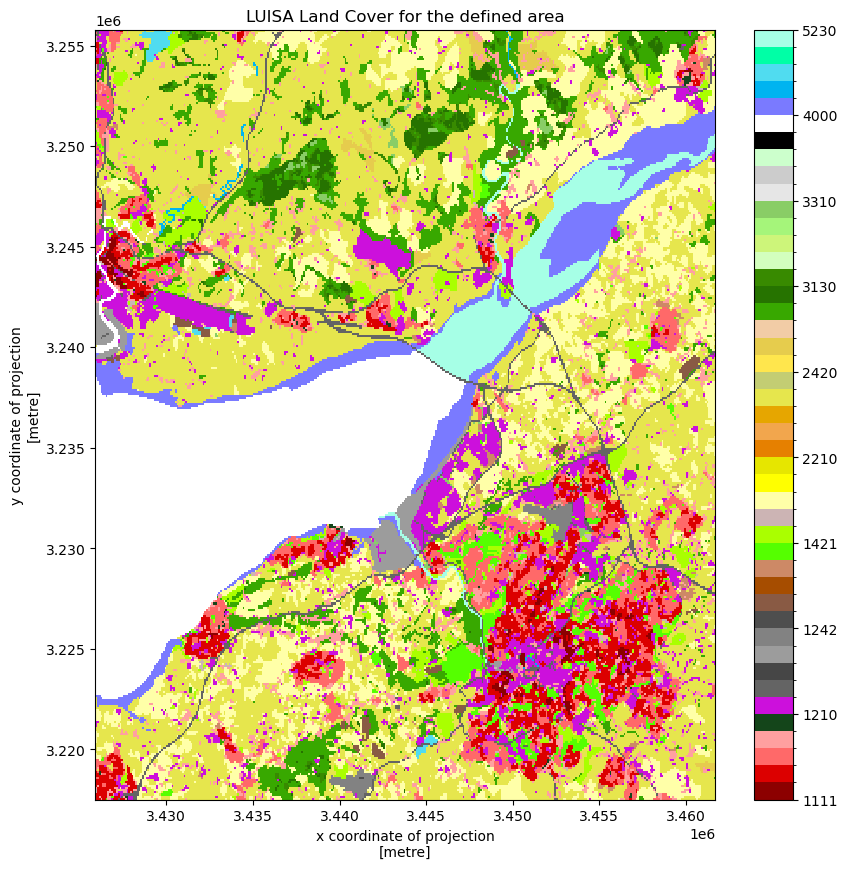

In [11]:
# Set the coordinate reference system (CRS) for the land use map to EPSG:3035
land_use.rio.write_crs(3035, inplace=True)

# Clip the land use map to the specified bounding box and CRS
land_use_small_area = land_use.rio.clip_box(*bbox, crs="EPSG:4326")

# Define values and colors for different land use classes
LUISA_values = [1111, 1121, 1122, 1123, 1130,
                1210, 1221, 1222, 1230, 1241,
                1242, 1310, 1320, 1330, 1410,
                1421, 1422, 2110, 2120, 2130,
                2210, 2220, 2230, 2310, 2410,
                2420, 2430, 2440, 3110, 3120,
                3130, 3210, 3220, 3230, 3240,
                3310, 3320, 3330, 3340, 3350,
                4000, 5110, 5120, 5210, 5220,
                5230]

LUISA_colors = ["#8c0000", "#dc0000", "#ff6969", "#ffa0a0", "#14451a",
                "#cc10dc", "#646464", "#464646", "#9c9c9c", "#828282",
                "#4e4e4e", "#895a44", "#a64d00", "#cd8966", "#55ff00",
                "#aaff00", "#ccb4b4", "#ffffa8", "#ffff00", "#e6e600",
                "#e68000", "#f2a64d", "#e6a600", "#e6e64d", "#c3cd73",
                "#ffe64d", "#e6cc4d", "#f2cca6", "#38a800", "#267300",
                "#388a00", "#d3ffbe", "#cdf57a", "#a5f57a", "#89cd66",
                "#e6e6e6", "#cccccc", "#ccffcc", "#000000", "#ffffff",
                "#7a7aff", "#00b4f0", "#50dcf0", "#00ffa6", "#a6ffe6",
                "#e6f2ff"]

# Plot the land use map using custom levels and colors
land_use_small_area.plot(levels=LUISA_values, colors=LUISA_colors, figsize=(10, 10))

# Set the title for the plot
plt.title('LUISA Land Cover for the defined area')


In [96]:
# Make plots of floodmaps loaded for the area of interest
plot_dir = os.path.join(data_dir,'floodmap_plots')
if not os.path.isdir(plot_dir): os.makedirs(plot_dir)

# Define maximum range of inundation depth for plotting purposes
vrange=[0,round(np.nanmax(floodmaps['inun'].sel(year=2080,scenario='rcp85',slr_percentile=95).isel(return_period=5).values))]

# function to plot a panel of plots corresponding to storms with different return periods
def plot_floodmap_scenarios(ds,year,scenario,slr_perc,vrange):
    fig,axs = plt.subplots(figsize=(15, 8),nrows=2,ncols=3,sharex=True,sharey=True,layout='constrained')
    for pp in range(0,6):
        bs=ds['inun'].sel(year=year,scenario=scenario,slr_percentile=slr_perc).isel(return_period=pp).plot(ax=axs[pp//3,pp%3],vmin=vrange1[0],vmax=vrange1[1],add_colorbar=False,cmap='turbo',alpha=0.5)
        ctx.add_basemap(axs[pp//3,pp%3],crs='EPSG:3035',source=ctx.providers.CartoDB.Positron, attribution_size=6)
        axs[pp//3,pp%3].set_title(f'1 in {ds.return_period.values[pp]} return period',fontsize=12)
        axs[pp//3,pp%3].xaxis.label.set_visible(False)
        axs[pp//3,pp%3].yaxis.label.set_visible(False)
    
    axs[0,0].yaxis.label.set_visible(True); axs[1,0].yaxis.label.set_visible(True); 
    axs[1,0].xaxis.label.set_visible(True); axs[1,1].xaxis.label.set_visible(True); axs[1,2].xaxis.label.set_visible(True)
    fig.colorbar(bs,ax=axs[:],orientation="vertical",pad=0.01,shrink=0.9,aspect=30).set_label(label=f'Coastal flood inundation height [m]',size=14)  
    plt.suptitle('Flood maps for extreme sea level rise scenarios \n' + f'Scenario {scenario.upper()}, year {year}',fontsize=12)
    return fig


In [ ]:
# plot for all scenarios
for year in years:
    for scenario in rcps:
        for slr_perc in percs:
            if (perc==95) & (scenario != 'rcp85'):
                continue
            fileout = os.path.join(plot_dir,'Floodmap_area_{}_{}_rpAll_Perc{}.png'.format(areaname, scenario, slr_perc))
            fig = plot_floodmap_scenarios(floodmaps,year,scenario,slr_perc,vrange)
            fig.savefig(fileout) 
            plt.close()

# show an example plot
fig=plot_floodmap_scenarios(floodmaps,2050,'rcp45',50,vrange)

#### Interpolate the land use data array

Next we need to interpolate the flood data into the land use map grid in order to be able to calculate the damage map.  
We can use the xarray [**interp_like()**](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp_like.html) function, that will interpolate the land use data into flood grid.  

In case our land use map was courses we would not like to actually interpolate the land use values between gridcells because then 'new' land use values will be created that do not have a meaning. To prevent that we are using method **'nearest'**, to assign the values to the nearest grid points.

In [49]:
floodmaps

<xarray.Dataset>
Dimensions:         (x: 56, y: 59, year: 4, return_period: 6, scenario: 4,
                     slr_percentile: 2)
Coordinates:
  * x               (x) float64 3.426e+06 3.426e+06 ... 3.461e+06 3.461e+06
  * y               (y) float64 3.256e+06 3.255e+06 ... 3.218e+06 3.218e+06
  * year            (year) int32 2020 2030 2050 2080
  * return_period   (return_period) int32 1 10 50 100 500 1000
  * scenario        (scenario) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * slr_percentile  (slr_percentile) int32 50 95
    spatial_ref     int32 0
Data variables:
    inun            (slr_percentile, scenario, return_period, year, y, x) float32 ...
Attributes:
    units:          m
    long_name:      Coastal flooding
    standard_name:  water_surface_height_above_reference_datum
    comment:        water_surface_reference_datum_altitude is given in file /...

In [146]:
# Reproject the clipped flood map to match the resolution and extent of the land use map

# Prepare empty dataset with new coordinates
floodmaps_resampled = xr.Dataset(coords=xr.Coordinates(floodmaps.coords))
floodmaps_resampled = floodmaps_resampled.assign_coords(x_new = land_use_small_area.x.values)
floodmaps_resampled = floodmaps_resampled.assign_coords(y_new = land_use_small_area.y.values)
floodmaps_resampled = floodmaps_resampled.drop_dims({'x','y'})
#floodmaps_resampled = floodmaps_resampled.reset_coords(names={'x','y'}, drop=True)
floodmaps_resampled = floodmaps_resampled.rename({'x_new': 'x','y_new': 'y'})
floodmaps_resampled


<xarray.Dataset>
Dimensions:         (year: 4, return_period: 6, scenario: 4, slr_percentile: 2,
                     x: 358, y: 383)
Coordinates:
  * year            (year) int32 2020 2030 2050 2080
  * return_period   (return_period) int32 1 10 50 100 500 1000
  * scenario        (scenario) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * slr_percentile  (slr_percentile) int32 50 95
    spatial_ref     int32 0
  * x               (x) float64 3.426e+06 3.426e+06 ... 3.462e+06 3.462e+06
  * y               (y) float64 3.256e+06 3.256e+06 ... 3.218e+06 3.218e+06
Data variables:
    *empty*

In [148]:
for year in years:
    for scenario in rcps:
        for slr_perc in percs:
            if (perc==95) & (scenario != 'rcp85'):
                continue
            for pp in range(0,6):
                ori_map = floodmaps['inun'].sel(year=year,scenario=scenario,slr_percentile=slr_perc).isel(return_period=pp)
                new_map = ori_map.rio.reproject_match(land_use_small_area, resampling=Resampling.bilinear)
                ds = new_map.to_dataset(); del new_map
                ds = ds.expand_dims(dim={'scenario':1,'year':1,'return_period':1,'slr_percentile':1})
                floodmaps_resampled.merge(ds)



In [123]:
floodmaps_resampled

<xarray.Dataset>
Dimensions:         (year: 4, return_period: 6, scenario: 4, slr_percentile: 2,
                     x: 358, y: 383)
Coordinates:
  * year            (year) int32 2020 2030 2050 2080
  * return_period   (return_period) int32 1 10 50 100 500 1000
  * scenario        (scenario) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * slr_percentile  (slr_percentile) int32 50 95
    spatial_ref     int32 0
  * x               (x) float64 3.426e+06 3.426e+06 ... 3.462e+06 3.462e+06
  * y               (y) float64 3.256e+06 3.256e+06 ... 3.218e+06 3.218e+06
Data variables:
    inun            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [105]:
floodmaps_resampled['inun'].sel(year=2050,scenario='rcp45',slr_percentile=50).isel(return_period=0).plot()

KeyError: "No variable named 'inun'. Variables on the dataset include ['year', 'return_period', 'scenario', 'slr_percentile', 'spatial_ref', 'x', 'y']"

In [ ]:
# check the new resolution of the floodmap
floodmaps_matched.rio.resolution()

For now we save them as tif so DamageScanner package can use them as input.

In [ ]:
# Create a new GeoTIFF file for the matched flood map
with rasterio.open(
    f'{data_dir}/floodmaps_matched.tif',
    'w',
    driver='GTiff',
    height=floodmaps_matched.shape[1],
    width=floodmaps_matched.shape[2],
    count=1,
    dtype=str(floodmaps_matched.dtype),
    crs=floodmaps_matched.rio.crs,
    transform=floodmaps_matched.rio.transform()
) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(floodmaps_matched.values)


In [ ]:
# Create a new GeoTIFF file for the clipped land use map
with rasterio.open(
    f'{data_dir}/land_use_small_area.tif',
    'w',
    driver='GTiff',
    height=land_use_small_area.shape[1],
    width=land_use_small_area.shape[2],
    count=1,
    dtype=str(land_use_small_area.dtype),
    crs=land_use_small_area.rio.crs,
    transform=land_use_small_area.rio.transform()
) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(land_use_small_area.values)


### Additional info for the LUISA land use maps

In order to assess the damage done by the flood we also need to assign a monetary value to the land use categories. We define this as the potential loss in €/m². Go into the provided **LUISA_damage_info_curves.xlsx** and tweak the information to your own region.

In [ ]:
# Read damage curve information from an Excel file into a pandas DataFrame
LUISA_info_damage_curve = pd.read_excel('LUISA_damage_info_curves.xlsx', index_col=0)

# Extract the 'total €/m²' column to get the maximum damage for reconstruction
maxdam = pd.DataFrame(LUISA_info_damage_curve['total €/m²'])

# Save the maximum damage values to a CSV file
maxdam.to_csv(f'{data_dir}/maxdam_luisa.csv')

# Display the first 10 rows of the resulting DataFrame
maxdam.head(10)


In [ ]:
# Create a new DataFrame for damage_curves_luisa by copying JRC_curves
damage_curves_luisa = JRC_curves.copy()

# Drop all columns in the new DataFrame
damage_curves_luisa.drop(damage_curves_luisa.columns, axis=1, inplace=True)

# Define building types for consideration
building_types = ['residential', 'commercial', 'industrial']

# For each land use class in maxdamage, create a new damage curve
for landuse in maxdam.index:
    # Find the ratio of building types in the class
    ratio = LUISA_info_damage_curve.loc[landuse, building_types].values

    # Create a new curve based on the ratios and JRC_curves
    damage_curves_luisa[landuse] = ratio[0] * JRC_curves.iloc[:, 0] + \
                                   ratio[1] * JRC_curves.iloc[:, 1] + \
                                   ratio[2] * JRC_curves.iloc[:, 2]

# Save the resulting damage curves to a CSV file
damage_curves_luisa.to_csv(f'{data_dir}/curves.csv')    

# Plot the vulnerability curves for the first 10 land cover types
damage_curves_luisa.iloc[:, 0:10].plot()
plt.title('Vulnerability curves for flood damages for the LUISA land cover types')
plt.ylabel('Damage (%)')
plt.xlabel('Inundation depth (m)')


## Calculate the damage using DamageScanner library

Now that we have all pieces of the puzzle in place, we can start doing the risk calculation. For this we are using the [DamageScanner](https://damagescanner.readthedocs.io/en/latest/index.html) python library which allows for an easy damage calculation. 

The DamageScanner takes the following data:
- The clipped and resampled flood map 
- The clipped landuse map
- The created vulnerability curves 
- A table of maximum damages per landuse category 

In [ ]:
# Define file paths for the flood map, land use map, vulnerability curves, and maximum damages
inun_map = os.path.join(data_dir, 'flood_small_area_matched.tif')
landuse_map = os.path.join(data_dir, 'land_use_small_area.tif')
curve_path = os.path.join(data_dir, 'curves.csv')
maxdam_path = os.path.join(data_dir, 'maxdam_luisa.csv')


In [ ]:
# Do the damage calculation and save the results as 'flood_scenario'
loss_df = RasterScanner(landuse_map,
                        inun_map,
                        curve_path,
                        maxdam_path, 
                        save = True, 
                        nan_value = None, 
                        scenario_name= f'{results_dir}/flood_scenario',
                        dtype = np.int64)

In [ ]:
# Obtain the LUISA legend and add it to the table of damages
LUISA_legend = LUISA_info_damage_curve['Description']

# Combine loss_df with LUISA_legend
catagory_damage = pd.concat([LUISA_legend, (loss_df[0])], axis=1)

# Convert the damages to million euros
catagory_damage['damage mln.'] = catagory_damage['damages'] / 10**6

# Drop the 'damages' column
catagory_damage.drop('damages', axis=1, inplace=True)

# Sort the values by damage in descending order
catagory_damage.sort_values(by='damage mln.', ascending=False, inplace=True)

# Display the resulting DataFrame
# catagory_damage


## Plot the results

Now we plot the damages to get a spatial view of what places are financially most affected.

In [ ]:
# Open a raster file representing flood damages for a specific scenario
damagemap = rxr.open_rasterio(f'{results_dir}/scenario200_damagemap.tif')

# Select values in the damagemap that are greater than 0
damagemap = damagemap.where(damagemap > 0)

# Create a plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the damagemap with a color map representing damages and a color bar
damagemap.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Damage [€]"})

# Set plot title and labels for X and Y coordinates
plt.title('Flood damages for 500 year return period')
plt.xlabel('X coordinate in the projection')
plt.ylabel('Y coordinate in the projection')

# Add a basemap background to the plot using Contextily
ctx.add_basemap(ax=ax, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

To get a better indication of why certain areas are damaged more than others, we also plot the floodmap and land use maps in one figure.

In [ ]:
# Create a 2x2 grid of plots with a size of 20x15 inches
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(20, 15))

# Plot flood damages on the first plot
damagemap.plot(ax=ax1, cmap='Reds', cbar_kwargs={'label': "Damage [€]"})
ax1.set_title('Flood damages for 500 year return period')
ax1.set_xlabel('X coordinate in the projection')
ax1.set_ylabel('Y coordinate in the projection')

# Plot inundation depth on the second plot
flood_small_area_matched.where(flood_small_area_matched > 0).plot(ax=ax2, cmap='Blues', cbar_kwargs={'label': "Inundation depth [m]"})
ax2.set_title('Flood depth for 500 year return period')
ax2.set_xlabel('X coordinate in the projection')
ax2.set_ylabel('Y coordinate in the projection')

# Plot land use on the third plot with custom colors
land_use_small_area.plot(ax=ax3, levels=LUISA_values, colors=LUISA_colors, cbar_kwargs={'label': "Land use class [-]"})
ax3.set_title('LUISA Land Cover for the defined area')
ax3.set_xlabel('X coordinate in the projection')
ax3.set_ylabel('Y coordinate in the projection')

# Remove the fourth plot (ax4)
ax4.remove()

# Add a map background to each plot using Contextily
ctx.add_basemap(ax1, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2, crs=flood_small_area_matched.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax3, crs=land_use_small_area.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Display the plot
plt.show()

Here we see both the the flood depths and the associated damages. What we notice is that high flood depths do not necesarilly corrolate to high damages. Can you see why? It can have two causes. Either the landuse does not have a high economic value, or the land use is very resilient to high water levels. Make sure to check the results and try to explain why high damages do or do not occur in case of high innundation. Find that something is wrong? Reiterate your assumptions made in the **LUISA_damage_info_curves.xlsx** and run the workflow again.

## Conclusions

:::{important}

In this risk workflow we learned:
 - How to get floodmaps and landuse maps for your specific region.
 - Assign each landuse with a vulnerability curve and maxmum damage.
 - Combining the flood (hazard), landuse (exposure), and the vulnerability curves (vulnerability) to obtain an economic damage estimate.
 - Understand where damage comes from and how exposure and vulnerability are an important determinant of risk
:::
